In [228]:
import pandas as pd
import yfinance as yf
import numpy as np
from hurst import compute_Hc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from src import data_loader as dl
from src import processing as proc
from src import feature_engineering as ft

In [229]:
df = dl.download_raw_data(start_date='2000-01-01', end_date='2025-12-31')
df = proc.prepare_market_data(df)
df = ft.add_spx_vix_features(df)
df_copy = df.copy()
df.columns

C:\Users\leogo\PycharmProjects\FinalProject\src\data_loader.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\leogo\PycharmProjects\FinalProject\src\data_loader.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download('^VIX', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Index(['SP500_Close', 'SP500_High', 'SP500_Low', 'SP500_Open', 'SP500_Volume',
       'VIX_Close', 'VIX_High', 'VIX_Low', 'VIX_Open', 'VIX_Volume',
       'daily_return', 'log_daily_return', '5d_return', '20d_return',
       '5d_volatility', '20d_volatility', '60d_volatility', 'vol_of_vol_20d',
       'realized_quarticity_20d', 'realized_skew_20d', 'realized_kurtosis_20d',
       'return_Zscore_20d', 'MA_20', 'MA_50', 'MA_200', 'slope_MA_20',
       'slope_MA_50', 'slope_MA_200', 'price_MA_20', 'price_MA_50',
       'price_MA_200', 'rolling_max', 'current_drawdown', 'max_drawdown_252d',
       'downside_dev_20d', 'autocorr_1d', 'autocorr_5d', 'autocorr_20d',
       'dVIX_1d', 'dVIX_5d', 'VIX_Zscore_20d', 'VIX_vol_20d',
       'realized_vol_20d_ann', 'VRP_Proxy', 'corr_ret_dVIX_20d', 'ret_x_VIX',
       'vol_x_VIX', 'vol_ratio', 'VIX_Zscore_X_DD', 'RSI_20', 'hurst_100d',
       'ADX_14'],
      dtype='object')

In [230]:
cols_to_drop = ['SP500_Close','VIX_Close','SP500_Open', 'SP500_High', 'SP500_Low', 'SP500_Volume','VIX_Open', 'VIX_High', 'VIX_Low', 'VIX_Volume','daily_return', '5d_return', 'MA_20', 'MA_50', 'MA_200', 'rolling_max', 'price_MA_20', 'price_MA_50', 'price_MA_200','autocorr_1d', 'autocorr_5d']
df = df.drop(columns=cols_to_drop)
df = df.dropna()
df.columns

Index(['log_daily_return', '20d_return', '5d_volatility', '20d_volatility',
       '60d_volatility', 'vol_of_vol_20d', 'realized_quarticity_20d',
       'realized_skew_20d', 'realized_kurtosis_20d', 'return_Zscore_20d',
       'slope_MA_20', 'slope_MA_50', 'slope_MA_200', 'current_drawdown',
       'max_drawdown_252d', 'downside_dev_20d', 'autocorr_20d', 'dVIX_1d',
       'dVIX_5d', 'VIX_Zscore_20d', 'VIX_vol_20d', 'realized_vol_20d_ann',
       'VRP_Proxy', 'corr_ret_dVIX_20d', 'ret_x_VIX', 'vol_x_VIX', 'vol_ratio',
       'VIX_Zscore_X_DD', 'RSI_20', 'hurst_100d', 'ADX_14'],
      dtype='object')

In [231]:
from __future__ import annotations

In [232]:

DEFAULT_FEATURE_COLS = ['log_daily_return', '20d_return', '5d_volatility', '20d_volatility',
       '60d_volatility', 'vol_of_vol_20d', 'realized_quarticity_20d',
       'realized_skew_20d', 'realized_kurtosis_20d', 'return_Zscore_20d',
       'slope_MA_20', 'slope_MA_50', 'slope_MA_200', 'current_drawdown',
       'max_drawdown_252d', 'downside_dev_20d', 'autocorr_20d', 'dVIX_1d',
       'dVIX_5d', 'VIX_Zscore_20d', 'VIX_vol_20d', 'realized_vol_20d_ann',
       'VRP_Proxy', 'corr_ret_dVIX_20d', 'ret_x_VIX', 'vol_x_VIX', 'vol_ratio',
       'VIX_Zscore_X_DD', 'RSI_20', 'hurst_100d', 'ADX_14']

df.columns

Index(['log_daily_return', '20d_return', '5d_volatility', '20d_volatility',
       '60d_volatility', 'vol_of_vol_20d', 'realized_quarticity_20d',
       'realized_skew_20d', 'realized_kurtosis_20d', 'return_Zscore_20d',
       'slope_MA_20', 'slope_MA_50', 'slope_MA_200', 'current_drawdown',
       'max_drawdown_252d', 'downside_dev_20d', 'autocorr_20d', 'dVIX_1d',
       'dVIX_5d', 'VIX_Zscore_20d', 'VIX_vol_20d', 'realized_vol_20d_ann',
       'VRP_Proxy', 'corr_ret_dVIX_20d', 'ret_x_VIX', 'vol_x_VIX', 'vol_ratio',
       'VIX_Zscore_X_DD', 'RSI_20', 'hurst_100d', 'ADX_14'],
      dtype='object')

In [233]:
def build_feature_matrix(
    df: pd.DataFrame,
    feature_cols: list[str] | None = None,
) -> tuple[np.ndarray, pd.Index, list[str]]:
    """
    From a feature-rich df, extract X matrix, dropping rows with NaNs
    in the selected feature columns.

    Returns:
        X           : np.ndarray (n_samples, n_features)
        index       : pd.Index of the rows kept (to align labels back)
        feature_cols: list[str] actually used
    """
    if feature_cols is None:
        feature_cols = DEFAULT_FEATURE_COLS

    # Keep only rows where all chosen features are available
    X_df = df[feature_cols].dropna()
    X = X_df.values
    idx = X_df.index

    return X, idx, feature_cols

df_features = build_feature_matrix(df, feature_cols=DEFAULT_FEATURE_COLS)
df_features

(array([[ 6.19392183e-03,  1.84563099e-03,  8.01009073e-03, ...,
          5.07183832e+01,  6.33125603e-01,  1.20693536e+01],
        [-6.52008388e-03, -1.89354895e-03,  8.95192924e-03, ...,
          4.92857729e+01,  6.17570889e-01,  1.21698960e+01],
        [-3.59482134e-03,  2.07189977e-03,  6.82139333e-03, ...,
          5.07994340e+01,  6.26601701e-01,  1.28633434e+01],
        ...,
        [ 9.02088600e-03, -1.81413796e-02,  1.19805734e-02, ...,
          4.37424323e+01,  5.58099283e-01,  6.67677262e+01],
        [ 6.88296944e-03, -1.13168803e-02,  1.20172238e-02, ...,
          4.62699793e+01,  5.68714627e-01,  6.54687969e+01],
        [ 5.34048734e-03,  3.92094217e-03,  3.82126105e-03, ...,
          5.13196423e+01,  5.74205008e-01,  6.49945421e+01]],
       shape=(6015, 31)),
 DatetimeIndex(['2002-01-04', '2002-01-07', '2002-01-08', '2002-01-09',
                '2002-01-10', '2002-01-11', '2002-01-14', '2002-01-15',
                '2002-01-16', '2002-01-17',
                

In [234]:
def scale_features(X: np.ndarray) -> tuple[np.ndarray, StandardScaler]:
    """
    Standardize features to zero mean, unit variance.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

x_scaled, scaler = scale_features(df_features[0])


Selected 15 principal components to explain at least 90% variance.


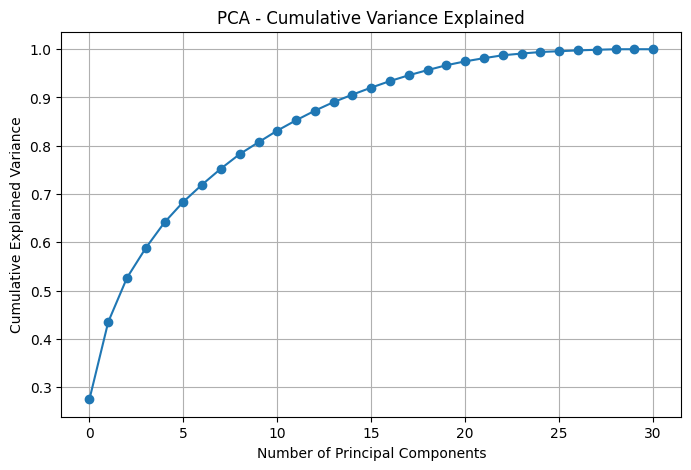

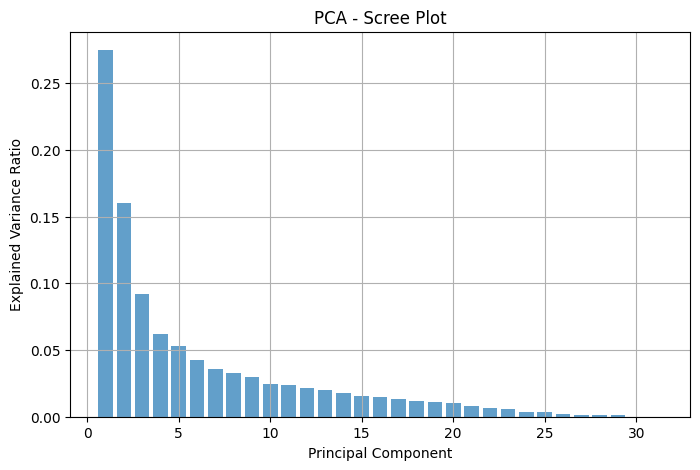

In [235]:
# PCA reduction (variance target)
def pca_analysis(
    x_scaled: np.ndarray,
    variance_target: float = 0.9,
) -> tuple[np.ndarray, int, PCA]:
    """
    Perform PCA on scaled features, reduce to n_components
    that explain at least variance_target of variance.

    Returns:
        X_pca_reduced : np.ndarray (n_samples, n_components)
        n_components  : int number of components selected
        pca           : fitted PCA object
    """
    pca = PCA()
    X_pca = pca.fit_transform(x_scaled)
    explained_var = pca.explained_variance_ratio_

    # Determine number of components to reach variance target
    n_components = np.argmax(np.cumsum(explained_var) >= variance_target) + 1
    X_pca_reduced = X_pca[:, :n_components]

    return X_pca_reduced, n_components, pca

X_pca_reduced, n_components, pca = pca_analysis(x_scaled, variance_target=0.9)
explained_var = pca.explained_variance_ratio_
print(f"Selected {n_components} principal components to explain at least 90% variance.")

# Show Cumulative Explained Variance Plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_var), marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Variance Explained")
plt.grid(True)
plt.show()

# Show Scree Plot
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Scree Plot")
plt.grid(True)
plt.show()


Silhouette scores for PCA reduced data: ['2: 0.2858', '3: 0.2039', '4: 0.183', '5: 0.1281', '6: 0.127', '7: 0.1303', '8: 0.1057']
Silhouette scores for raw scaled data: ['2: 0.2745', '3: 0.1922', '4: 0.1684', '5: 0.1107', '6: 0.1102', '7: 0.1135', '8: 0.0864']

Chose PCA features with k=2 (silhouette=0.286)


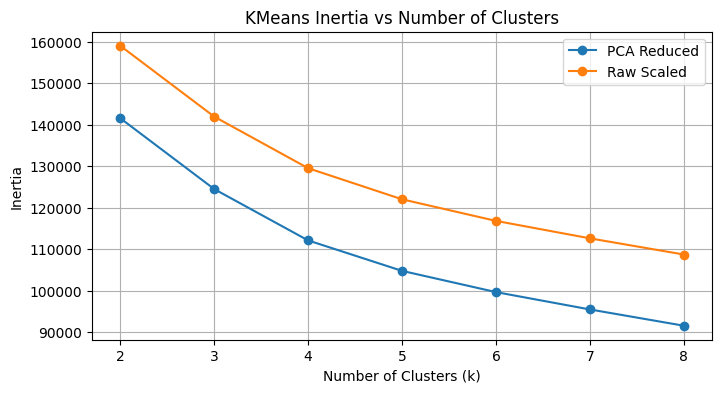

PCA Reduced                Raw Scaled               
            k        inertia          k        inertia
0           2  141604.299950          2  159060.892899
1           3  124534.178398          3  141988.304548
2           4  112157.905701          4  129558.607473
3           5  104819.456845          5  122062.293052
4           6   99705.008556          6  116860.592326
5           7   95525.007078          7  112655.980716
6           8   91604.979296          8  108754.831616

In [236]:
def kmeans_sweep(
    X_scaled: np.ndarray,
    k_min: int = 2,
    k_max: int = 8,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Fit KMeans for k in [k_min, k_max], compute inertia and silhouette.
    Returns a DataFrame with results.
    """
    results = []
    scores_silhouette = {}

    for k in range(k_min, k_max + 1):
        km_model = KMeans(n_clusters=k, n_init=50, random_state=random_state)
        labels = km_model.fit_predict(X_scaled)

        inertia = km_model.inertia_
        sil = silhouette_score(X_scaled, labels) if k > 1 else np.nan

        results.append(
            {"k": k, "inertia": inertia}
        )
        scores_silhouette[k] = sil

    return pd.DataFrame(results), scores_silhouette

kmeans_results_pca, scores_silhouette_pca = kmeans_sweep(X_pca_reduced, k_min=2, k_max=8)
kmeans_results_raw, scores_silhouette_raw = kmeans_sweep(x_scaled, k_min=2, k_max=8)

print(f"Silhouette scores for PCA reduced data: {[f"{k}: {round(v, 4)}" for k,v in scores_silhouette_pca.items()]}")
print(f"Silhouette scores for raw scaled data: {[f"{k}: {round(v, 4)}" for k,v in scores_silhouette_raw.items()]}")

# Choose representation with higher best silhouette
best_k_raw = max(scores_silhouette_raw, key=scores_silhouette_raw.get)
best_k_pca = max(scores_silhouette_pca, key=scores_silhouette_pca.get)

use_pca = scores_silhouette_pca[best_k_pca] >= scores_silhouette_raw[best_k_raw]
rep = "PCA" if use_pca else "RAW"
best_k = best_k_pca if use_pca else best_k_raw
X_final = X_pca_reduced if use_pca else x_scaled

print(f"\nChose {rep} features with k={best_k} "
      f"(silhouette={max(scores_silhouette_pca.values()) if use_pca else max(scores_silhouette_raw.values()):.3f})")

#visualize inertia to see the elbow point
plt.figure(figsize=(8, 4))
plt.plot(kmeans_results_pca['k'], kmeans_results_pca['inertia'], marker='o', label='PCA Reduced')
plt.plot(kmeans_results_raw['k'], kmeans_results_raw['inertia'], marker='o', label='Raw Scaled')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(kmeans_results_pca['k'])
plt.legend()
plt.grid()
plt.show()

kmeans_result = pd.concat([kmeans_results_pca,kmeans_results_raw],axis=1, keys=['PCA Reduced', 'Raw Scaled'])
kmeans_result


In [237]:
def fit_kmeans(
    X_scaled: np.ndarray,
    n_clusters: int,
    random_state: int = 42,
) -> tuple[np.ndarray, KMeans]:
    """
    Fit final KMeans with chosen n_clusters.
    Returns labels and fitted model.
    """
    km = KMeans(n_clusters=n_clusters, n_init=50, random_state=random_state)
    labels = km.fit_predict(X_scaled)
    return labels, km
kmeans_labels, kmeans_model = fit_kmeans(X_final, n_clusters=best_k)
print(np.unique(kmeans_labels, return_counts=True))

(array([0, 1], dtype=int32), array([1328, 4687]))


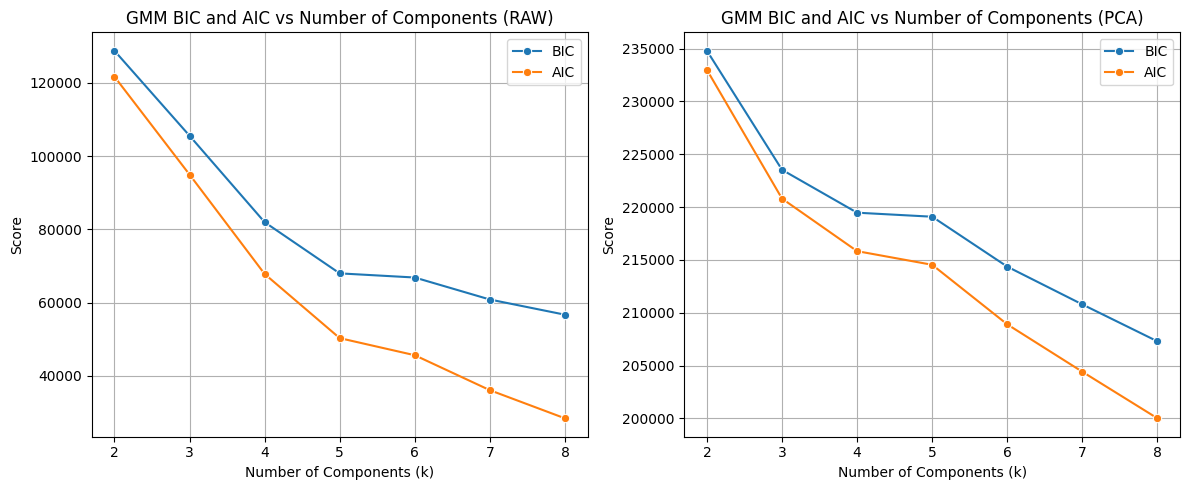

,space,k,bic,aic,silhouette
0,RAW,2,128797.020501,121726.398233,0.206620
1,RAW,3,105584.105036,94974.820628,0.161573
2,RAW,4,81973.807185,67825.860637,0.087805
3,RAW,5,67986.970262,50300.361575,0.050339
4,RAW,6,66855.650785,45630.379958,0.062766
5,RAW,7,60845.861442,36081.928475,0.047195
6,RAW,8,56697.324054,28394.728947,0.033019
7,PCA,2,234796.522429,232980.277278,0.258504
8,PCA,3,223526.735166,220799.016433,0.118983
9,PCA,4,219466.531520,215827.339205,0.120808


In [238]:
def gmm_sweep_labeled(
    X: np.ndarray,
    space: str,
    k_min: int = 2,
    k_max: int = 8,
    covariance_type: str = "full",
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Fit GaussianMixture for k in [k_min, k_max], compute BIC, AIC, and silhouette.
    Returns a long-form DataFrame with columns:
    ['space', 'k', 'bic', 'aic', 'silhouette'].
    """
    rows = []

    for k in range(k_min, k_max + 1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=covariance_type,
            random_state=random_state,
        )
        gmm.fit(X)

        bic = gmm.bic(X)
        aic = gmm.aic(X)
        labels = gmm.predict(X)
        sil = silhouette_score(X, labels) if k > 1 else np.nan

        rows.append({
            "space": space,
            "k": k,
            "bic": bic,
            "aic": aic,
            "silhouette": sil,
        })

    return pd.DataFrame(rows)


gmm_results_raw = gmm_sweep_labeled(x_scaled, space="RAW", k_min=2, k_max=8)
gmm_results_pca = gmm_sweep_labeled(X_pca_reduced, space="PCA", k_min=2, k_max=8)

gmm_results_all = pd.concat([gmm_results_raw, gmm_results_pca], ignore_index=True)

# display bic and aic and silhouette scores based on numbers of clusters and create 2 different plots for raw and pca, 1 only for raw and 1 only for pca
import seaborn as sns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=gmm_results_all[gmm_results_all['space'] == 'RAW'], x='k', y='bic', marker='o', label='BIC')
sns.lineplot(data=gmm_results_all[gmm_results_all['space'] == 'RAW'], x='k', y='aic', marker='o', label='AIC')
plt.title('GMM BIC and AIC vs Number of Components (RAW)')
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
sns.lineplot(data=gmm_results_all[gmm_results_all['space'] == 'PCA'], x='k', y='bic', marker='o', label='BIC')
sns.lineplot(data=gmm_results_all[gmm_results_all['space'] == 'PCA'], x='k', y='aic', marker='o', label='AIC')
plt.title('GMM BIC and AIC vs Number of Components (PCA)')
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

gmm_results_all


In [239]:

# Depending on previous scores choose best representation and number of components
def fit_gmm(
    X_scaled: np.ndarray,
    n_components: int,
    covariance_type: str = "full",
    random_state: int = 42,
) -> tuple[np.ndarray, GaussianMixture]:
    """
    Fit final GaussianMixture with chosen n_components.
    Returns labels (hard assignment) and fitted model.
    """
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        random_state=random_state,
    )
    labels = gmm.fit_predict(X_scaled)
    return labels, gmm

# Assumption: choose PCA representation with 2 components based on previous analysis
gmm_labels, gmm_model = fit_gmm(X_pca_reduced, n_components=2)
print(np.unique(gmm_labels, return_counts=True))


(array([0, 1]), array([4375, 1640]))


In [240]:
# PCA loadings (interpretation)
loadings = pd.DataFrame(
    pca.components_.T,
    index=DEFAULT_FEATURE_COLS,
    columns=[f"PC{i+1}" for i in range(len(pca.components_))]
)

def top_loadings(load_df, pc="PC1", n=8):
    s = load_df[pc].sort_values()
    return pd.concat([s.head(n), s.tail(n)])

print("\nTop loadings for PC1:")
display(top_loadings(loadings, "PC1"))
print("\nTop loadings for PC2:")
display(top_loadings(loadings, "PC2"))


Top loadings for PC1:


current_drawdown          -0.254011
slope_MA_20               -0.207896
VRP_Proxy                 -0.206191
20d_return                -0.176055
RSI_20                    -0.166219
slope_MA_50               -0.154812
max_drawdown_252d         -0.146990
ret_x_VIX                 -0.118957
vol_ratio                  0.234345
vol_of_vol_20d             0.240457
realized_quarticity_20d    0.248608
60d_volatility             0.273641
5d_volatility              0.292386
20d_volatility             0.333268
realized_vol_20d_ann       0.333268
downside_dev_20d           0.334023
Name: PC1, dtype: float64


Top loadings for PC2:


log_daily_return        -0.399330
return_Zscore_20d       -0.373047
VIX_Zscore_X_DD         -0.323446
ret_x_VIX               -0.165233
20d_return              -0.110480
RSI_20                  -0.102480
vol_ratio               -0.096828
current_drawdown        -0.055464
realized_kurtosis_20d    0.027875
5d_volatility            0.031570
downside_dev_20d         0.042047
VRP_Proxy                0.106553
dVIX_5d                  0.233937
VIX_Zscore_20d           0.378298
vol_x_VIX                0.385497
dVIX_1d                  0.410893
Name: PC2, dtype: float64

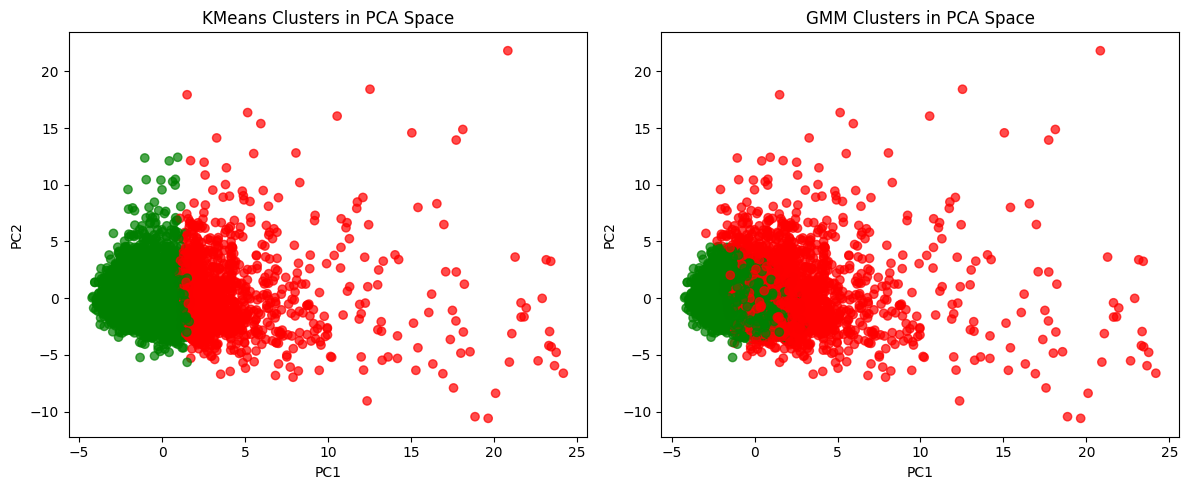

In [241]:
# Visualize clusters in PCA space
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_clusters_pca(
    X_pca: np.ndarray,
    labels_km: np.ndarray,
    labels_gmm: np.ndarray,
) -> None:
    """
    Scatter plot of KMeans and GMM cluster assignments in PCA space
    using ONLY blue and red colors (cycling if k > 2).
    """
    # Blue–Red colormap (cycles if more clusters)
    cmap_br = ListedColormap(["green", "red", "green", "red"])

    plt.figure(figsize=(12, 5))

    # --- KMeans plot ---
    plt.subplot(1, 2, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap=ListedColormap(["red","green"]), alpha=0.7)
    plt.title('KMeans Clusters in PCA Space')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # --- GMM plot ---
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_gmm, cmap=cmap_br, alpha=0.7)
    plt.title('GMM Clusters in PCA Space')
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.tight_layout()

plot_clusters_pca(X_pca_reduced, kmeans_labels, gmm_labels)


In [242]:
def plot_sp500_with_clusters(
    df_prices: pd.DataFrame,
    idx: pd.Index,
    labels_km: np.ndarray,
    labels_gmm: np.ndarray,
    close_col: str = "SP500_Close",
) -> None:
    """
    Plot S&P 500 close with KMeans and GMM cluster assignments
    overlaid as colored points.
    """

    # Subset to the rows actually used for clustering
    df_used = df_prices.loc[idx, [close_col]].copy()
    df_used["cluster_km"] = labels_km
    df_used["cluster_gmm"] = labels_gmm

    plt.figure(figsize=(14, 6))

    # --- KMeans regimes ---
    plt.subplot(1, 2, 1)
    plt.plot(df_used.index, df_used[close_col], color="black", linewidth=1, alpha=0.6)
    plt.scatter(
        df_used.index,
        df_used[close_col],
        c=df_used["cluster_km"],
        cmap=ListedColormap(["red","green"]),
        s=0.5,
        alpha=0.9,
    )
    plt.title("S&P 500 with KMeans Regimes")
    plt.xlabel("Date")
    plt.ylabel(close_col)
    plt.grid(alpha=0.3)

    # --- GMM regimes ---
    plt.subplot(1, 2, 2)
    plt.plot(df_used.index, df_used[close_col], color="black", linewidth=1, alpha=0.6)
    plt.scatter(
        df_used.index,
        df_used[close_col],
        c=df_used["cluster_gmm"],
        cmap=ListedColormap(["green","red"]),
        s=0.5,
        alpha=0.9,
    )
    plt.title("S&P 500 with GMM Regimes")
    plt.xlabel("Date")
    plt.ylabel(close_col)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

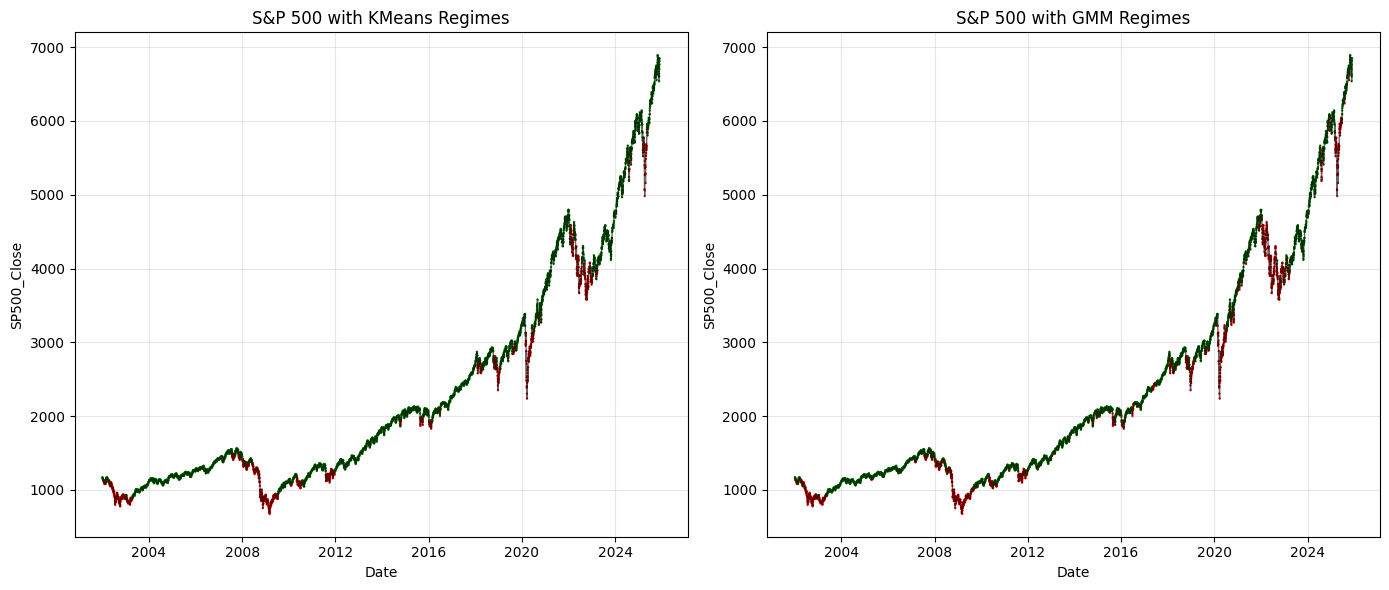

In [243]:
idx = df_features[1]  # index of rows used in X / X_pca_reduced

plot_sp500_with_clusters(
    df_prices=df_copy,
    idx=idx,
    labels_km=kmeans_labels,
    labels_gmm=gmm_labels,
)


In [250]:
def assign_kmeans_regime(df: pd.DataFrame,
                         idx: pd.Index,
                         labels: np.ndarray,
                         col_name: str = "KMeans_Regime") -> pd.DataFrame:
    df = df.copy()
    df[col_name] = np.nan
    df.loc[idx, col_name] = labels
    df[col_name] = df[col_name].astype("Int64")
    return df
df_copy = assign_kmeans_regime(df_copy, idx, kmeans_labels)
df_copy['KMeans_Regime'].value_counts()


KMeans_Regime
1    4687
0    1328
Name: count, dtype: Int64

In [251]:
summary = df_copy.groupby("KMeans_Regime")[
    ["20d_volatility", "VIX_Close", "current_drawdown", "VRP_Proxy"]
].agg(["mean", "median", "std", "count"])